In [1]:
import os
import sys

import h5py

import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
import ipywidgets as widgets

from joblib import Parallel, delayed


# Defining the segments on skeletons & contours 

### get skeletons, contours and contour widths from hdf5 files

In [2]:
# get skeleton hdf5 files
path_to_skels = "/share/data/longterm/2/Jerneja_Behaviour/Tierpsy_skeleton_files_jerneja/"
# path_to_skels = "/share/data/longterm/10/Marios Tierpsy analysis/30042020_120fps/analysis 120fps/Results/"
skel_files_list = [os.path.join(root,name) for root,dirs,names in os.walk(path_to_skels) for name in names 
                   if name.endswith('skeletons.hdf5')]

In [3]:
# Pick a random skeleton 

skel_file = random.choice(skel_files_list)
print(skel_file)
skel_obj = h5py.File(skel_file, 'r')

/share/data/longterm/2/Jerneja_Behaviour/Tierpsy_skeleton_files_jerneja/20180817/Results/20180817_152616_1_5m0s_quinpirole0003_None_None_skeletons.hdf5


In [4]:
sample_file = '/share/data/longterm/2/Jerneja_Behaviour/Tierpsy_skeleton_files_jerneja/20180823_2/Results/20180823_133410_1_5m0s_alphamethyl_None_None_skeletons.hdf5'
skel_obj = h5py.File(sample_file, 'r')

In [5]:
# get skeleton array, contour arrays (2), cont widths

contour_width = np.array(skel_obj['contour_width'])
skeleton_array = np.array(skel_obj['skeleton'])
skeleton_length = np.array(skel_obj['skeleton_length'])
contour_array_1 = np.array(skel_obj['contour_side1'])
contour_array_2 = np.array(skel_obj['contour_side2'])

### Calculate neck points

In [6]:
def get_neckpoint(cont_widths):
    
    
    diff_contour = np.nanmean(np.diff(cont_widths), axis=0)
    diff_contour = diff_contour[3:22]
    neck_point = np.argmin(diff_contour)+4
    
    return neck_point

In [7]:
neck_point = get_neckpoint(contour_width)
print(neck_point)

12


### Calculate the segment indices

In [ ]:
def segment_partitions(neck):
    
    segments_ind = {
                'head' : int(np.round(neck/2))/48,
                'neck' : neck/48,
                'tail_6' : int(np.round((49-neck)/2)+neck)/48, 
                'tail_3' : int(np.round((49-neck)/4)+neck)/48,
                'tail_9' : int(np.round(3*(49-neck)/4)+neck)/48,
            }
    
    return segments_ind

In [ ]:
max_skel_index = contour_width.shape[-1] - 1 # default : 48

In [ ]:
segments_ind_dflt = segment_partitions(neck_point)
segments_ind = {k:int(round(x*max_skel_index)) for k,x in segments_ind_dflt.items()}

### Define contours of segmented regions

- split contours into segments depending on the index of the segments
- reconstruct with cont-width edge lines (note : edges)
- note: might need to reverse to get a closed circle

In [ ]:
def segment_contours(contour_1, contour_2, segments_ind):
    
#     from itertools import groupby
#     from operator import itemgetter
    
    contour_dict = {}
    indices = np.array([0,max_skel_index])
    indices = np.insert(indices, 1, list(segments_ind.values()))
    indices = sorted(indices)
    #indices_nested = [list(map(itemgetter(1), g)) for k, g in groupby(enumerate(indices), lambda x: x[0]-x[1])]
    indices_nested = [[indices[i],indices[i+1]] for i in range(len(indices)-1)]
    print(indices_nested)
    
    for i, ind_bound in enumerate(indices_nested):
        
        contour_1_x = contour_1[ind_bound[0]:ind_bound[1]+1,0]
        contour_2_x = contour_2[ind_bound[0]:ind_bound[1]+1,0]
        contour_2_x = np.flipud(contour_2_x)
        
        contour_1_y = contour_1[ind_bound[0]:ind_bound[1]+1,1]
        contour_2_y = contour_2[ind_bound[0]:ind_bound[1]+1,1]
        contour_2_y = np.flipud(contour_2_y)
        
        contour_x = np.concatenate((contour_1_x, contour_2_x))
        contour_y = np.concatenate((contour_1_y, contour_2_y))
        contour_dict[i] = np.array([contour_x, contour_y])
        
    return contour_dict
    
    

In [ ]:
contour_dict = segment_contours(contour_array_1[1,:,:], contour_array_2[1,:,:], segments_ind)

In [ ]:
contour_dict[0].shape

In [ ]:
for key, val in contour_dict.items():
   
    plt.fill(contour_dict[key][0],contour_dict[key][1])

### Redefine body parts

In [ ]:
def body_partitions(neck):
    
    segments_ind = {        
                'neck' : [(neck-1)/48, (neck+2)/48], 
                'head' : [0, (neck-1)/48],
                'head_tip' : [0, int(np.round((neck-1)/2))/48],
                'head_base' : [int(np.round((neck-1)/2))/48, (neck-1)/48],
                'tail': [(neck+2)/48 ,1],
                'tail_base': [(neck+2)/48 ,int(np.round((49-(neck+2))/4)+(neck+2))/48],
                'tail_mid_proximal': [int(np.round((49-(neck+2))/4)+(neck+2))/48, int(np.round(2*(49-(neck+2))/4)+(neck+2))/48],
                'tail_mid_distal': [int(np.round(2*(49-(neck+2))/4)+(neck+2))/48, int(np.round(3*(49-(neck+2))/4)+(neck+2))/48],
                'tail_tip': [int(np.round(3*(49-(neck+2))/4)+(neck+2))/48,1]
            }
    
    return segments_ind

In [ ]:
max_skel_index = contour_width.shape[-1] - 1

In [ ]:
segments_ind_dflt = body_partitions(neck_point)
segments_ind = { k: [int(round(x[0]*max_skel_index)),int(round(x[1]*max_skel_index))] for k,x in segments_ind_dflt.items()}

In [ ]:
segments_ind

In [ ]:
def segment_contours(contour_1, contour_2, segments_ind):
    
    contour_dict = {}
    
    for key, ind_bound in segments_ind.items():
        
        contour_1_x = contour_1[ind_bound[0]:ind_bound[1]+1,0]
        contour_2_x = contour_2[ind_bound[0]:ind_bound[1]+1,0]
        contour_2_x = np.flipud(contour_2_x)
        
        contour_1_y = contour_1[ind_bound[0]:ind_bound[1]+1,1]
        contour_2_y = contour_2[ind_bound[0]:ind_bound[1]+1,1]
        contour_2_y = np.flipud(contour_2_y)
        
        contour_x = np.concatenate((contour_1_x, contour_2_x))
        contour_y = np.concatenate((contour_1_y, contour_2_y))
        contour_dict[key] = np.array([contour_x, contour_y])
        
    return contour_dict
    
    

In [ ]:
contour_dict = segment_contours(contour_array_1[500,:,:], contour_array_2[500,:,:], segments_ind)

In [ ]:
for key, val in contour_dict.items():
    if key in ['neck','head','tail']:
        plt.fill(contour_dict[key][0],contour_dict[key][1])

In [ ]:
def calc_centroids(segments_ind, neck_point):
    centroid_dict = {}
    
    for key, value in segments_ind.items():
        
        centroid_dict[key] = round((value[0] + value[1])/2)
    
    centroid_dict['neck'] = neck_point
#     centroid_dict['tail'] = segments_ind['tail_mid_distal'][0]
#     centroid_dict['head'] = segments_ind['head_base'][0]
    
    centroid_dict['tail'] = segments_ind['tail_mid_distal'][0]
    centroid_dict['head'] = segments_ind['head_base'][0]
    return centroid_dict

### Make the annotated plots for random frames

In [ ]:
slider_frame = widgets.IntSlider(value= 0,
                                        min=0,
                                        max= contour_width.shape[0]-1,
                                        step=1,
                                        description='Frames:',
                                        disabled=False,
                                        continuous_update=False,
                                        orientation='horizontal',
                                        readout=True,
                                        readout_format='d')

cpal = sns.color_palette("hls",10)
color_dict = {}
for key, color in zip(contour_dict.keys(), cpal):
    color_dict[key] = color
    
@widgets.interact
def plot_ciona_segments(ind_frame = slider_frame):
    
    fig, axes = plt.subplots(2,1,figsize=(10,15))
    
    contour_all_x = np.concatenate((contour_array_1[ind_frame,:,0],np.flipud(contour_array_2[ind_frame,:,0])))
    contour_all_y = np.concatenate((contour_array_1[ind_frame,:,1],np.flipud(contour_array_2[ind_frame,:,1])))
    
    contour_dict = segment_contours(contour_array_1[ind_frame,:,:], contour_array_2[ind_frame,:,:], segments_ind)
    for key, val in contour_dict.items():
        
        axes[1].fill(contour_dict[key][0],contour_dict[key][1],label=key, color = color_dict[key], alpha=0.5)
        
        if key in ['tail','head', 'neck']:
            axes[0].fill(contour_dict[key][0],contour_dict[key][1],label=key,linewidth=5, color = color_dict[key], alpha=0.5)
        if key in ['tail','head']:
            axes[1].plot(contour_dict[key][0],contour_dict[key][1],label=key,linewidth=5, color = color_dict[key]) 
    
    
    print(skeleton_length[ind_frame])
    
    centroid_dict = calc_centroids(segments_ind, neck_point)
    for key, centroid in centroid_dict.items():
        #if key not in ['head','tail']:
        axes[1].scatter(skeleton_array[ind_frame,centroid,0],skeleton_array[ind_frame,centroid,1],c='k')
        if key in ['neck', 'head','tail']:
            axes[0].scatter(skeleton_array[ind_frame,centroid,0],skeleton_array[ind_frame,centroid,1],c='k')
            
    
# # Plot the skeleteon and the contours
#     axes.plot(skeleton_array[ind_frame,:,0],skeleton_array[ind_frame,:,1],'k')
#     

## Plot the segment indices (jerneja)
#     for key, index in segments_ind.items():    
#         axes.scatter(skeleton_array[ind_frame,index,0],skeleton_array[ind_frame,index,1],c='k')
#         axes.scatter(contour_array_1[ind_frame,index,0],contour_array_1[ind_frame,index,1],c='k')
#         axes.scatter(contour_array_2[ind_frame,index,0],contour_array_2[ind_frame,index,1],c='k', label=key)
    
    for ax in axes:
        ax.set_aspect('equal')
        ax.autoscale(True)
        ax.legend()

# Framewise calculations

### Calculate neck points : framewise

In [8]:
def calc_neck_points(cont_widths):
    
    print(cont_widths.shape)
    diff_contour = np.diff(cont_widths)
    diff_contour = diff_contour[:,3:22]
    print(diff_contour.shape)
    neck_points = np.argmin(diff_contour, axis=1)+4
    
    return neck_points
    

In [9]:
neck_point_array = calc_neck_points(contour_width)

(8994, 49)
(8994, 19)


### Calculate segment indices : framewise

In [ ]:
# def body_partitions_framewise(neck):
    
#     segments_ind = {        
#                 'neck' : [(neck-1)/48, (neck+1)/48], 
#                 'head' : [0, (neck-1)/48],
# #                 'head_tip' : [0, int(np.round((neck-1)/2))/48],
# #                 'head_base' : [int(np.round((neck-1)/2))/48, (neck-1)/48],
#                 'tail': [(neck+1)/48 ,1],
#                 'tail_base': [(neck+1)/48 ,int(np.round((49-(neck+1))/5)+(neck+1))/48],
#                 'tail_pre_mid': [int(np.round((49-(neck+1))/5)+(neck+1))/48, int(np.round(2*(49-(neck+1))/5)+(neck+1))/48],
#                 'tail_mid': [ int(np.round(2*(49-(neck+1))/5)+(neck+1))/48,int(np.round(3*(49-(neck+1))/5)+(neck+1))/48],
#                 'tail_post_mid': [int(np.round(3*(49-(neck+1))/5)+(neck+1))/48, int(np.round(4*(49-(neck+1))/5)+(neck+1))/48],
#                 'tail_tip': [int(np.round(4*(49-(neck+1))/5)+(neck+1))/48,1]
#             }
    
#     return segments_ind

In [10]:
def body_partitions_framewise(neck):
    
    #NOTE: to be changed for feature calculations as mutually exclusive index ranges
    
    tail_length = 48-(neck+2)+1
    tail_seg_len = int(np.round(tail_length / 5))
    segments_ind = {        
                'neck' : [(neck-1), (neck+1)], 
                'head' : [0, (neck-1)],
                'tail': [(neck+1) ,48],
        
                'tail_base': [(neck+1) ,(neck+2)+ tail_seg_len ],
                'tail_pre_mid': [(neck+2)+ tail_seg_len, (neck+2)+ 2*tail_seg_len ],
                'tail_mid': [(neck+2)+ 2*tail_seg_len, (neck+2)+ 3*tail_seg_len ],
                'tail_post_mid': [(neck+2)+ 3*tail_seg_len, (neck+2)+ 4*tail_seg_len ],
                'tail_tip': [(neck+2)+ 4*tail_seg_len ,48]
            }
    
    return segments_ind

In [11]:
def get_segment_indices(neck_point):
    
    max_skel_index = contour_width.shape[-1] - 1 # default : 48
    segments_ind_dflt = body_partitions_framewise(neck_point)
    segments_ind = { k: [int(round(x[0]*max_skel_index)),int(round(x[1]*max_skel_index))] for k,x in segments_ind_dflt.items()}
#     return segments_ind
    return segments_ind_dflt

In [12]:
def segment_contours_fw(contour_1, contour_2, segments_ind):
    
    contour_dict = {}
    
    for key, ind_bound in segments_ind.items():
        
        contour_1_x = contour_1[ind_bound[0]:ind_bound[1]+1,0]
        contour_2_x = contour_2[ind_bound[0]:ind_bound[1]+1,0]
        contour_2_x = np.flipud(contour_2_x)
        
        contour_1_y = contour_1[ind_bound[0]:ind_bound[1]+1,1]
        contour_2_y = contour_2[ind_bound[0]:ind_bound[1]+1,1]
        contour_2_y = np.flipud(contour_2_y)
        
        contour_x = np.concatenate((contour_1_x, contour_2_x))
        contour_y = np.concatenate((contour_1_y, contour_2_y))
        contour_dict[key] = np.array([contour_x, contour_y])
        
    return contour_dict
    

In [13]:
def calc_centroids_fw(segments_ind, neck_point):
    centroid_dict = {}
    
    for key, value in segments_ind.items():
        
        centroid_dict[key] = int(np.round((value[0] + value[1])/2))
    
    centroid_dict['neck'] = neck_point
#     centroid_dict['tail'] = segments_ind['tail_mid_distal'][0]
#     centroid_dict['head'] = segments_ind['head_base'][0]
    
    centroid_dict['tail'] = centroid_dict['tail_mid']
    #centroid_dict['head'] = segments_ind['head_base'][0]
    return centroid_dict

In [66]:
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager@1.26

In [67]:
!jupyter lab --version

1.2.6


Button(description='Save figure', style=ButtonStyle())

interactive(children=(IntSlider(value=0, continuous_update=False, description='Frames:', max=8993), Output()),…

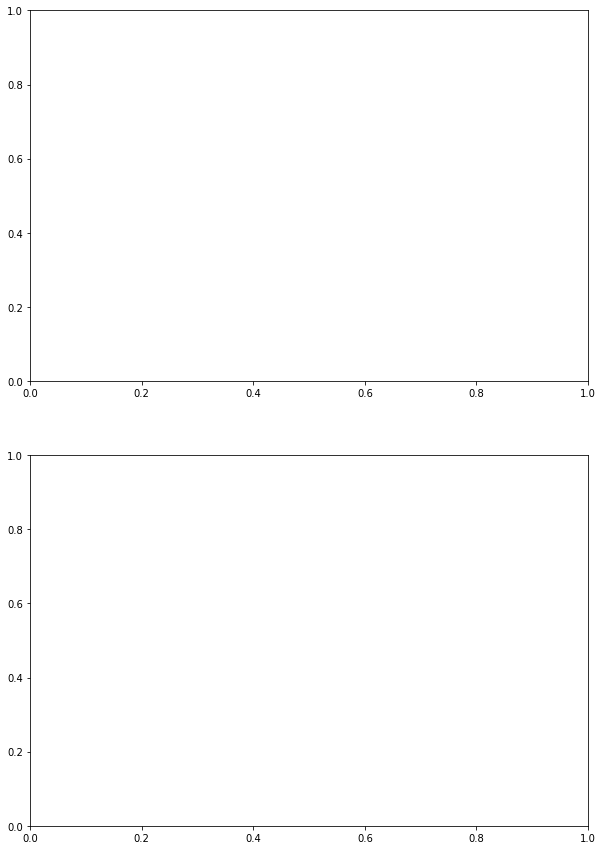

In [14]:
slider_frame = widgets.IntSlider(value= 0,
                                        min=0,
                                        max= contour_width.shape[0]-1,
                                        step=1,
                                        description='Frames:',
                                        disabled=False,
                                        continuous_update=False,
                                        orientation='horizontal',
                                        readout=True,
                                        readout_format='d')

cpal = sns.color_palette("hls",9)
#cpal = sns.hls_palette(8, l=.5, s=.5)
# color_dict = {}
# color_dict = {'neck' : sns.xkcd_rgb["salmon"], 
#                 'head': sns.xkcd_rgb["orange"] ,
#                 'tail': sns.xkcd_rgb["brick red"] ,
#                 'tail_base': sns.xkcd_rgb["dark pink"],
#                 'tail_pre_mid': sns.xkcd_rgb["rose"],
#                 'tail_mid': sns.xkcd_rgb["mauve"],
#                 'tail_post_mid': sns.xkcd_rgb["dusty rose"],
#                 'tail_tip': sns.xkcd_rgb["pale red"]}

save_button = widgets.Button(description='Save figure')
display(save_button)

@widgets.interact
def plot_ciona_segments(ind_frame = slider_frame):
    
    fig, axes = plt.subplots(2,1,figsize=(10,15))
    
    
    contour_all_x = np.concatenate((contour_array_1[ind_frame,:,0],np.flipud(contour_array_2[ind_frame,:,0])))
    contour_all_y = np.concatenate((contour_array_1[ind_frame,:,1],np.flipud(contour_array_2[ind_frame,:,1])))
    
    segments_ind = get_segment_indices(neck_point_array[ind_frame])
    
    contour_dict = segment_contours_fw(contour_array_1[ind_frame,:,:], contour_array_2[ind_frame,:,:], segments_ind)
    
    for key, color in zip(contour_dict.keys(), cpal):
        color_dict[key] = color
    
    for key, val in contour_dict.items():
        if key not in ['tail']:
            axes[1].fill(contour_dict[key][0],contour_dict[key][1],label=key, color = color_dict[key], alpha=0.5)
        
        if key in ['tail','head', 'neck']:
            axes[0].fill(contour_dict[key][0],contour_dict[key][1],label=key,linewidth=5, color = color_dict[key], alpha=0.5)
        if key in ['tail','head']:
            axes[1].plot(contour_dict[key][0],contour_dict[key][1],label=key,linewidth=5, color = color_dict[key]) 
    
    
    print(skeleton_length[ind_frame])
    print(neck_point_array[ind_frame])
    centroid_dict = calc_centroids_fw(segments_ind, neck_point_array[ind_frame])
    print(centroid_dict)
    for key, centroid in centroid_dict.items():
        #if key not in ['head','tail']:
        axes[1].scatter(skeleton_array[ind_frame,centroid,0],skeleton_array[ind_frame,centroid,1],c='k')
        if key in ['neck', 'head','tail']:
            axes[0].scatter(skeleton_array[ind_frame,centroid,0],skeleton_array[ind_frame,centroid,1],c='k')
            
    
# # Plot the skeleteon and the contours
#     axes.plot(skeleton_array[ind_frame,:,0],skeleton_array[ind_frame,:,1],'k')
#     

## Plot the segment indices (jerneja)
#     for key, index in segments_ind.items():    
#         axes.scatter(skeleton_array[ind_frame,index,0],skeleton_array[ind_frame,index,1],c='k')
#         axes.scatter(contour_array_1[ind_frame,index,0],contour_array_1[ind_frame,index,1],c='k')
#         axes.scatter(contour_array_2[ind_frame,index,0],contour_array_2[ind_frame,index,1],c='k', label=key)
    
    for ax in axes:
        ax.set_aspect('equal')
        ax.autoscale(True)
        ax.legend()
        
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    
        
#     save_button.on_click(plt.savefig(f'annotted_{slider_frame.value}.png')) 

In [15]:
slider_frame = widgets.IntSlider(value= 0,
                                        min=0,
                                        max= contour_width.shape[0]-1,
                                        step=1,
                                        description='Frames:',
                                        disabled=False,
                                        continuous_update=False,
                                        orientation='horizontal',
                                        readout=True,
                                        readout_format='d')

cpal = sns.color_palette("hls",9)
#cpal = sns.hls_palette(8, l=.5, s=.5)
color_dict = {}
# color_dict = {'neck' : sns.xkcd_rgb["salmon"], 
#                 'head': sns.xkcd_rgb["orange"] ,
#                 'tail': sns.xkcd_rgb["brick red"] ,
#                 'tail_base': sns.xkcd_rgb["dark pink"],
#                 'tail_pre_mid': sns.xkcd_rgb["rose"],
#                 'tail_mid': sns.xkcd_rgb["mauve"],
#                 'tail_post_mid': sns.xkcd_rgb["dusty rose"],
#                 'tail_tip': sns.xkcd_rgb["pale red"]}



@widgets.interact
def plot_ciona_segments(ind_frame = slider_frame):
    
    fig, axes = plt.subplots(1,1,figsize=(10,15))
    
    
    contour_all_x = np.concatenate((contour_array_1[ind_frame,:,0],np.flipud(contour_array_2[ind_frame,:,0])))
    contour_all_y = np.concatenate((contour_array_1[ind_frame,:,1],np.flipud(contour_array_2[ind_frame,:,1])))
    
    segments_ind = get_segment_indices(neck_point_array[ind_frame])
    
    contour_dict = segment_contours_fw(contour_array_1[ind_frame,:,:], contour_array_2[ind_frame,:,:], segments_ind)
    
    for key, color in zip(contour_dict.keys(), cpal):
        color_dict[key] = color
    
    # Plot the segments areas and borders/contours
    for key, val in contour_dict.items():
        if key not in ['tail']:
            axes.fill(contour_dict[key][0],contour_dict[key][1],label=key, color = color_dict[key], alpha=0.5)
        
#         if key in ['tail','head', 'neck']:
#             axes[0].fill(contour_dict[key][0],contour_dict[key][1],label=key,linewidth=5, color = color_dict[key], alpha=0.5)
#         if key in ['tail', 'head']:
#             axes.plot(contour_dict[key][0],contour_dict[key][1],label=key,linewidth=5, color = color_dict[key]) 
    
    
    print(skeleton_length[ind_frame])
    print(neck_point_array[ind_frame])
    
    ## Plot the centroids
    
    centroid_dict = calc_centroids_fw(segments_ind, neck_point_array[ind_frame])
    for key, centroid in centroid_dict.items():
        #if key not in ['head','tail']:
        axes.scatter(skeleton_array[ind_frame,centroid,0],skeleton_array[ind_frame,centroid,1],c='k')
#         if key in ['neck', 'head','tail']:
#             axes[0].scatter(skeleton_array[ind_frame,centroid,0],skeleton_array[ind_frame,centroid,1],c='k')
            
    
#     for ax in axes:
    axes.set_aspect('equal')
    axes.autoscale(True)
    axes.legend()
        
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)
        
#     save_button = widgets.Button(description='Save figure')
#     display(save_button)
        
#     save_button.on_click(plt.savefig(f'annotted_{slider_frame.value}.png')) 

    fig.savefig('cionas_segment_annotated.svg')

interactive(children=(IntSlider(value=0, continuous_update=False, description='Frames:', max=8993), Output()),…

#### Tests

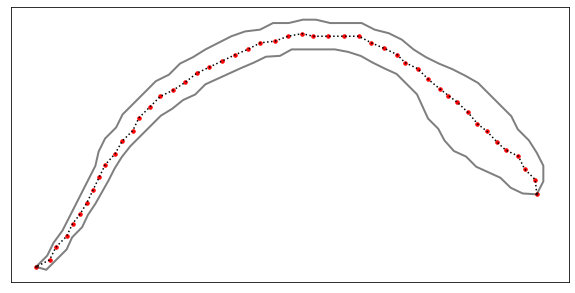

In [41]:
fig, axes = plt.subplots(1,1,figsize=(10,15))
axes.scatter(skeleton_array[0,:,0],skeleton_array[0,:,1],c='r', s = 12)
axes.plot(skeleton_array[0,:,0],skeleton_array[0,:,1], color = 'k', linestyle = ':')
axes.plot(contour_array_1[0,:,0],contour_array_1[0,:,1], color = 'k', linewidth = 2, alpha = 0.5)
axes.plot(contour_array_2[0,:,0],contour_array_2[0,:,1], color = 'k', linewidth = 2, alpha = 0.5)
axes.set_aspect('equal')
axes.autoscale(True)
axes.get_xaxis().set_visible(False)
axes.get_yaxis().set_visible(False)
fig.savefig('cionas_tierpsy_49points_fig1panelC.svg')

In [ ]:
tips = sns.load_dataset("tips")

In [ ]:
tips

In [17]:
def get_indices(neck):
    
    tail_length = 48-(neck+2)+1
    tail_seg_len = int(np.round(tail_length / 5))
    segments_ind = {        
                'neck' : [(neck-1), (neck+1)], 
                'head' : [0, (neck-2)],
                'tail': [(neck+2) ,48],
        
                'tail_base': [(neck+2) ,(neck+2)+ tail_seg_len -1],
                'tail_pre_mid': [(neck+2)+ tail_seg_len, (neck+2)+ 2*tail_seg_len -1],
                'tail_mid': [(neck+2)+ 2*tail_seg_len, (neck+2)+ 3*tail_seg_len -1],
                'tail_post_mid': [(neck+2)+ 3*tail_seg_len, (neck+2)+ 4*tail_seg_len -1],
                'tail_tip': [(neck+2)+ 4*tail_seg_len ,48]
            }
    
    return segments_ind
    

In [24]:
indices_test = get_indices(15)

In [25]:
indices_test

{'neck': [14, 16],
 'head': [0, 13],
 'tail': [17, 48],
 'tail_base': [17, 22],
 'tail_pre_mid': [23, 28],
 'tail_mid': [29, 34],
 'tail_post_mid': [35, 40],
 'tail_tip': [41, 48]}